# Plot results from ROS bag

In [21]:
import rosbag2_py
import os
from nav_msgs.msg import Odometry
from geometry_msgs.msg import Pose
from rclpy.serialization import deserialize_message
import matplotlib.pyplot as plt
from project.utils import angle_from_quaternion

print(os.getcwd())
bag_file = "/home/ubuntu/34761-Exercises/src/project/bag_files/test1"
reader = rosbag2_py.SequentialReader()
storage_options = rosbag2_py.StorageOptions(uri=bag_file, storage_id='sqlite3')
converter_options = rosbag2_py.ConverterOptions(input_serialization_format='cdr', output_serialization_format='cdr')
reader.open(storage_options, converter_options)

# Create empty lists to store the data
topics = ["/odom", "/particle_estimation_stack", "/particle_estimation_own"]
data_keys = ["x", "y", "angle", "Timestamp"]
data_dict = {topic: {key: [] for key in data_keys} for topic in topics}

# Collect data
topics = set()
while reader.has_next():
    topic, data, timestamp = reader.read_next()
    topics.add(topic)
    if topic in data_dict.keys():
        data_dict[topic]["Timestamp"].append(timestamp)
        # Deserialize the message
        msg = None
        if topic == "/odom":
            msg = deserialize_message(data, Odometry())
            data_dict[topic]["x"].append(msg.pose.pose.position.x)
            data_dict[topic]["y"].append(msg.pose.pose.position.y)
            data_dict[topic]["angle"].append(angle_from_quaternion(msg.pose.pose.orientation))
        elif topic == "/particle_estimation_stack" or topic == "/particle_estimation_own":
            msg = deserialize_message(data, Pose())
            data_dict[topic]["x"].append(msg.position.x)
            data_dict[topic]["y"].append(msg.position.y)
            data_dict[topic]["angle"].append(angle_from_quaternion(msg.orientation))

# Fix timestamps to start from 0 and from ns to seconds
latest_first_time = max([min(data_dict[key]["Timestamp"]) for key in data_dict.keys()])
for key in data_dict.keys():
    data_dict[key]["Timestamp"] = [(t - latest_first_time) / 1e9 for t in data_dict[key]["Timestamp"]]

/home/ubuntu/34761-Exercises/src/project


[INFO] [1713996396.712801691] [rosbag2_storage]: Opened database '/home/ubuntu/34761-Exercises/src/project/bag_files/test1/test1_0.db3' for READ_ONLY.


In [23]:
latest_first_time / 1e9

1713992903.2490134

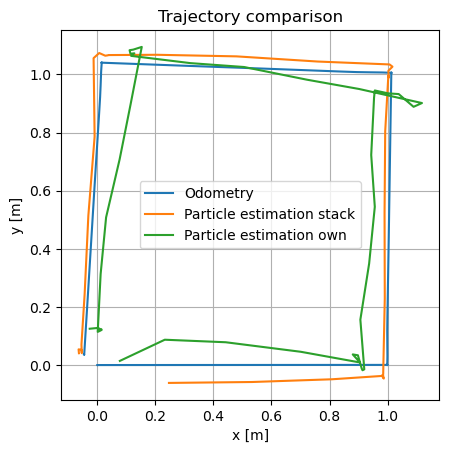

In [18]:
# Plot data
plt.figure()
plt.plot(data_dict["/odom"]["x"], data_dict["/odom"]["y"], label="Odometry")
plt.plot(data_dict["/particle_estimation_stack"]["x"], data_dict["/particle_estimation_stack"]["y"], label="Particle estimation stack")
plt.plot(data_dict["/particle_estimation_own"]["x"], data_dict["/particle_estimation_own"]["y"], label="Particle estimation own")
plt.legend()
plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.title("Trajectory comparison")
plt.grid()
plt.gca().set_aspect('equal', adjustable='box')
    
plt.show()

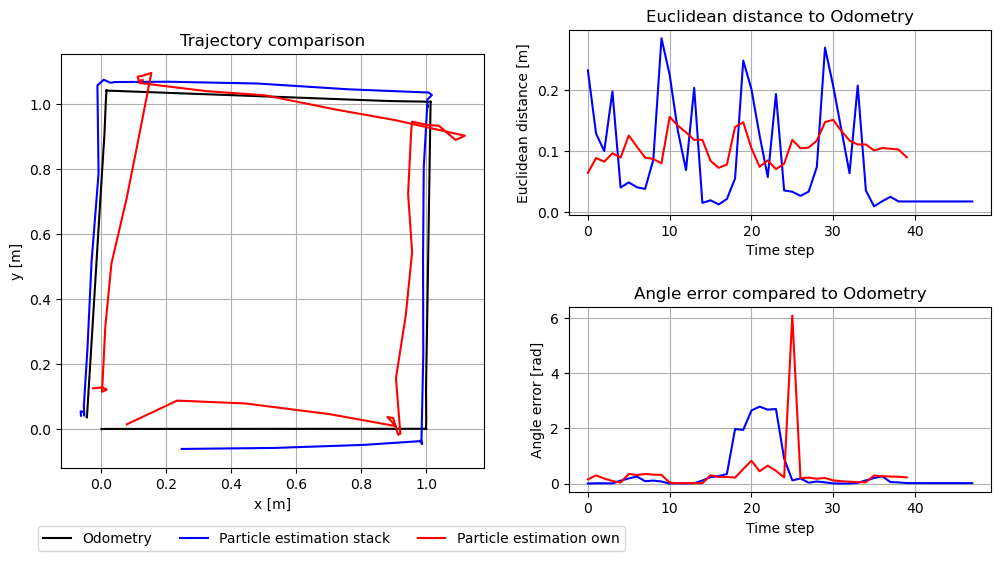

In [28]:
import numpy as np

# Plot Euclidean distance
odom_x = np.array(data_dict["/odom"]["x"])
odom_y = np.array(data_dict["/odom"]["y"])
stack_x = np.array(data_dict["/particle_estimation_stack"]["x"])
stack_y = np.array(data_dict["/particle_estimation_stack"]["y"])
own_x = np.array(data_dict["/particle_estimation_own"]["x"])
own_y = np.array(data_dict["/particle_estimation_own"]["y"])
odom_angle = np.array(data_dict["/odom"]["angle"])
stack_angle = np.array(data_dict["/particle_estimation_stack"]["angle"])
own_angle = np.array(data_dict["/particle_estimation_own"]["angle"])
# Convert timestamps to numpy arrays
odom_timestamps = np.array(data_dict["/odom"]["Timestamp"])
stack_timestamps = np.array(data_dict["/particle_estimation_stack"]["Timestamp"])
own_timestamps = np.array(data_dict["/particle_estimation_own"]["Timestamp"])

# Find the indices of the closest Odometry timestamps
stack_indices = np.searchsorted(odom_timestamps, stack_timestamps)
own_indices = np.searchsorted(odom_timestamps, own_timestamps)

# Use these indices to get the corresponding Odometry data
odom_x_stack = odom_x[stack_indices]
odom_y_stack = odom_y[stack_indices]
odom_angle_stack = odom_angle[stack_indices]
odom_x_own = odom_x[own_indices]
odom_y_own = odom_y[own_indices]
odom_angle_own = odom_angle[own_indices]

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Create a gridspec
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1], width_ratios=[1, 1])

# Create subplots
fig = plt.figure(figsize=(12, 6))
ax1 = plt.subplot(gs[:, 0])  # Trajectory comparison plot
ax2 = plt.subplot(gs[0, 1])  # Euclidean distance plot
ax3 = plt.subplot(gs[1, 1])  # Angle error plot

# Plot trajectories
ax1.plot(data_dict["/odom"]["x"], data_dict["/odom"]["y"], color='black', label="Odometry")
ax1.plot(data_dict["/particle_estimation_stack"]["x"], data_dict["/particle_estimation_stack"]["y"], color='blue', label="Particle estimation stack")
ax1.plot(data_dict["/particle_estimation_own"]["x"], data_dict["/particle_estimation_own"]["y"], color='red', label="Particle estimation own")
ax1.set_xlabel("x [m]")
ax1.set_ylabel("y [m]")
ax1.set_title("Trajectory comparison")
ax1.grid()
ax1.set_aspect('equal', adjustable='box')

# Now use these new Odometry arrays in your distance and angle error calculations
ax2.plot(np.sqrt((odom_x_stack - stack_x)**2 + (odom_y_stack - stack_y)**2), color='blue', label="Stack distance to Odometry")
ax2.plot(np.sqrt((odom_x_own - own_x)**2 + (odom_y_own - own_y)**2), color='red', label="Own distance to Odometry")
ax2.set_xlabel("Time step")
ax2.set_ylabel("Euclidean distance [m]")
ax2.set_title("Euclidean distance to Odometry")
ax2.grid()

ax3.plot(np.abs(odom_angle_stack - stack_angle), color='blue', label="Stack angle error")
ax3.plot(np.abs(odom_angle_own - own_angle), color='red', label="Own angle error")
ax3.set_xlabel("Time step")
ax3.set_ylabel("Angle error [rad]")
ax3.set_title("Angle error compared to Odometry")
ax3.grid()

# Create a common legend for all plots
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.35, 0), ncol=3)

plt.subplots_adjust(hspace=0.5)
plt.show()